## Anomaly Detection System
Implementation of an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the `through-put` (mb/s) and `latency` (ms) of response of each server. While your servers were operating, you collected `m = 307` examples of how they were behaving, and thus have an unlabeled dataset ${x^{1}, ..., x^{m}}$. You suspect that the vast majority of these examples are *normal* (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then __find values that have very low probability and hence can be considered anomalies__.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from scipy.io    import loadmat
from pathlib     import Path

In [2]:
# set root directory
path_root = Path("C:/Users/giann/data-science-core")
os.chdir(path_root)
print(f'- Root directory = {os.getcwd()}')

- Root directory = C:\Users\giann\data-science-core


In [3]:
path_dataset = path_root / 'dataset/ex8data1.mat'
mat = loadmat(path_dataset)  # load mat-file
print(mat.keys())
del(mat['__header__'])
del(mat['__version__'])
del(mat['__globals__'])
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
dict_keys(['X', 'Xval', 'yval'])


In [4]:
### Get train (unlabed data)
data_train = pd.DataFrame(data = mat['X'], columns = ['latency', 'through-put'] )
data_train.head(3)

,latency,through-put
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181


In [5]:
# get test data (labeled data)
data_test = np.concatenate((mat['Xval'], mat['yval']), axis = 1)
data_test = pd.DataFrame(data = data_test, columns = ['latency', 'through-put', 'anomaly'] )
data_test.head(3)

,latency,through-put,anomaly
0,15.790260,14.921024,0.0
1,13.639619,15.329955,0.0
2,14.865899,16.473865,0.0


<Figure size 432x288 with 0 Axes>

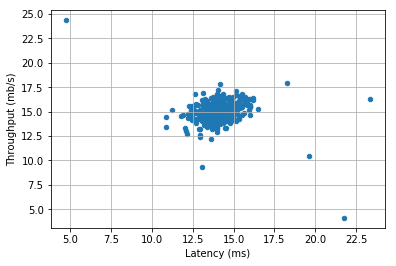

In [6]:
# Visualize the example dataset
plt.figure()
ax = data_train.plot(kind = 'scatter', x = 'latency', y = 'through-put')
ax = plt.xlabel('Latency (ms)');
ax = plt.ylabel('Throughput (mb/s)');
ax = plt.grid()
plt.show()

### Estimate the dataset statistics
To perform anomaly detection, you will first need to fit a model to the data's distribution, in this case mean $\mu$ and covariance matrix $\Sigma$.

In [9]:
# Estimate mean (mu) and variance (sigma2)
mu = data_train.mean(axis = 'index', skipna = True)
Sigma2 = data_train.cov()
print(f"o train feature mean \n {mu} \n")
print(f"o train feature variacne \n {Sigma2}")

o train feature mean 
 latency        14.112226
through-put    14.997711
dtype: float64 

o train feature variacne 
               latency  through-put
latency      1.838620    -0.227865
through-put -0.227865     1.715333


In [11]:
def multivariateGaussian(X, mu, Sigma2) :
    """
    Computes the probability density function of the multivariate gaussian distribution.
    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
    treated as the covariance matrix.     
    """
    # get number of mean values (# features)
    k = len(mu)
    # (X - mu)
    X = X - mu
    X = X.values
    # probability density function
    C = (2*np.pi)**(-k/2)*np.linalg.det(Sigma2)**(-0.5) 
    exponent = -0.5 * np.sum(np.matmul(X, np.linalg.pinv(Sigma2)) * X, axis = 1)
    p = C * np.exp(exponent)
    return p

p = multivariateGaussian(data_train, mu, Sigma2)

### Selecting the threshold $\epsilon$
Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold using the **F1** score on a **cross validation set**.

For this, we will use a cross validation set ${(x_{cv}^{1}, y_{cv}^{1}), ...,  (x_{cv}^{m_{cv}}, y_{cv}^{m_{cv}})}$ where the label `y = 1` corresponds to an anomalous example, and `y = 0` corresponds to a normal example. For each cross validation example, we will compute $p(x_{cv}^{i})$. The vector of all of these probabilities $p(x_{cv}^{1}), ..., p(x_{cv}^{m_{cv}})$ is passed to `selectThreshold.m` in the vector `pval`. The corresponding labels $y_{cv}^{1}, ..., y_{cv}^{m_{cv}}$ is passed to the same function in the vector `yval`.

In [13]:
Xval = data_test.drop('anomaly', axis = 1)
pval = multivariateGaussian(Xval, mu, Sigma2);
yval = data_test['anomaly'].values

The function `selectThreshold.m` returns two values: the first is the selected threshold  $\epsilon$. If a sample $x$ has a low probability $p(x) < \epsilon$, then it is considered to be an **anomaly**. The function also returns the **F1 score**, which tells you how well you're doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, the resulting F1 score. The F1 score is computed using **precision** (prec) and **recall** (rec):
\begin{equation*}
F_{1} = \frac{2 \cdot prec \cdot rec}{prec + rec}
\end{equation*}
where:
\begin{align}
prec & = \frac{tp}{tp + fp} \\
rec  & = \frac{tp}{tp + fn} 
\end{align}
with :
- **tp** a.k.a *true positives*: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.
- **fp** a.k.a *false positives*: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- **fn** a.k.a. *false negatives*: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In [14]:
def selectThreshold(yval, pval) :
    """
    Finds the best threshold to use for selecting outliers based on the results from a
    validation set (pval) and the ground truth (yval).    
    """

    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (max(pval) - min(pval)) / 1000

    for epsilon in np.arange(min(pval), max(pval), stepsize) :
        #print(epsilon)
        cvPredictions = (pval < epsilon);
        # true positive | false positive | false negative
        tp = np.sum((cvPredictions == 1) & (yval == 1)) # true positive 
        fp = np.sum((cvPredictions == 1) & (yval == 0)) # false positive
        fn = np.sum((cvPredictions == 0) & (yval == 1)) # false negative
        # get precision and recall -> F1-score
        prec = tp/(tp+fp);
        rec  = tp/(tp+fn);
        F1   = (2 * prec * rec)/(prec + rec);    

        if F1 > bestF1 :
            bestF1      = F1
            bestEpsilon = epsilon

    return (bestEpsilon, bestF1)
    
(epsilon, F1) = selectThreshold(yval, pval)

C:\Users\giann\Anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [15]:
print(f'Best epsilon found using cross-validation: {epsilon}')
print(f'Best F1 on Cross Validation Set: {F1}');
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation: 9.03624067615638e-05
Best F1 on Cross Validation Set: 0.8750000000000001
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


In [16]:
# Find the outliers in the training set and plot the
outliers = data_train[p < epsilon]

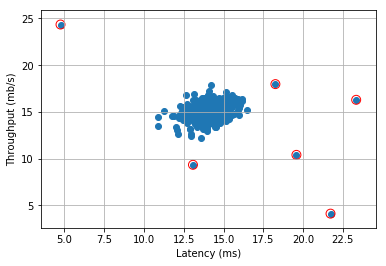

In [17]:
#  Draw a red circle around those outliers
# Visualize the example dataset
plt.figure()
ax = plt.scatter(x = data_train['latency'], y = data_train['through-put'])
ax = plt.scatter(x = outliers['latency']  , y = outliers['through-put'], s=80, facecolors = 'none', edgecolors = 'r')
ax = plt.xlabel('Latency (ms)');
ax = plt.ylabel('Throughput (mb/s)');
ax = plt.grid()
plt.show()

## Multidimensional Outliers
In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

In [18]:
# Loads the second dataset. 
path_dataset = path_root / 'dataset/ex8data2.mat'
mat = loadmat(path_dataset)  # load mat-file
print(mat.keys())
del(mat['__header__'])
del(mat['__version__'])
del(mat['__globals__'])
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])
dict_keys(['X', 'Xval', 'yval'])


In [19]:
# Get train (unlabed data)
data_train = pd.DataFrame(data = mat['X'])
print(f"o shape = {data_train.shape}")
print(data_train.head(3))

o shape = (1000, 11)
         0          1          2          3          4          5          6   \
0  6.653114  13.689702  17.552845 -11.933497  -5.756409  15.435921 -12.136752   
1 -5.630542 -18.937667  18.644624  -6.155825 -25.988864  15.409553 -16.595516   
2  9.721525  -9.982489  15.571434 -32.224266  -5.595799  24.321383   0.832774   

          7         8          9          10  
0   8.224123 -4.884024   5.349335  17.351372  
1   9.454654 -2.877173  -6.009420  19.210636  
2  10.794555  0.727575  10.392975   7.085995  


In [20]:
# get test data (labeled data)
data_test = np.concatenate((mat['Xval'], mat['yval']), axis = 1)
data_test = pd.DataFrame(data = data_test)
print(f"o shape = {data_test.shape}")
print(data_test.head(3))

o shape = (100, 12)
          0          1          2          3         4          5         6   \
0  18.271283 -12.359268   5.000970   1.611472  1.088592  29.314410 -8.313531   
1  -3.193070 -19.705821   6.528556 -21.570858  3.050556  23.477503 -1.133420   
2  -5.256678 -12.918720  25.435141  -7.231568  3.647838  12.366550 -6.512076   

          7          8          9          10   11  
0  36.438338  -9.476679 -25.928183   7.108628  1.0  
1  12.688409 -10.968301  -1.198666   1.908441  0.0  
2   8.750902  -0.768755  -3.261094  13.729474  0.0  


In [33]:
# Estimate mean (mu) and variance (sigma2)
mu = data_train.mean(axis = 'index', skipna = True)
Sigma2 = data_train.cov()

# patch neglect covariance to match the example
for i in range(Sigma2.shape[0]) :
    for j in range(Sigma2.shape[0]) :
        if i != j :
            Sigma2.iloc[i,j] = 0

print(f"o train feature mean \n {mu} \n")
print(f"o train feature variance \n {Sigma2}")

o train feature mean 
 0      4.939400
1     -9.637268
2     13.814707
3    -10.464489
4     -7.956229
5     10.199504
6     -6.019408
7      7.969829
8     -6.253182
9      2.324513
10     8.473723
dtype: float64 

o train feature variacne 
           0          1          2          3          4          5   \
0   61.03593   0.000000   0.000000   0.000000   0.000000   0.000000   
1    0.00000  53.258981   0.000000   0.000000   0.000000   0.000000   
2    0.00000   0.000000  58.574037   0.000000   0.000000   0.000000   
3    0.00000   0.000000   0.000000  84.288326   0.000000   0.000000   
4    0.00000   0.000000   0.000000   0.000000  65.333926   0.000000   
5    0.00000   0.000000   0.000000   0.000000   0.000000  89.664542   
6    0.00000   0.000000   0.000000   0.000000   0.000000   0.000000   
7    0.00000   0.000000   0.000000   0.000000   0.000000   0.000000   
8    0.00000   0.000000   0.000000   0.000000   0.000000   0.000000   
9    0.00000   0.000000   0.000000   0.000000  

In [34]:
#  Training set 
p = multivariateGaussian(data_train, mu, Sigma2)

In [35]:
# Cross-validation set
#pval = multivariateGaussian(Xval, mu, sigma2);
Xval = data_test.drop(11, axis = 1)
pval = multivariateGaussian(Xval, mu, Sigma2);
yval = data_test[11].values

In [36]:
# Find the best threshold
(epsilon, F1) = selectThreshold(yval, pval)

C:\Users\giann\Anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [37]:
print(f'Best epsilon found using cross-validation: {epsilon}');
print(f'   (you should see a value epsilon of about 1.38e-18)');
print(f'Best F1 on Cross Validation Set:  {F1}');
print(f'   (you should see a Best F1 value of 0.615385)');
print(f'# Outliers found: {np.sum(p < epsilon)}');

Best epsilon found using cross-validation: 1.3716606750407376e-18
   (you should see a value epsilon of about 1.38e-18)
Best F1 on Cross Validation Set:  0.6153846153846154
   (you should see a Best F1 value of 0.615385)
# Outliers found: 117
